In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from XtendedCorrel import hoeffding
from scipy.stats import kruskal
# from extracted_dfs import get_genres

In [3]:
with open("../scrape/games.json", "r") as file:
    json_data = json.load(file)

df = pd.json_normalize(json_data, sep='_')
print(df.columns)
df.drop(columns=[
    'tags',
    'genres',
    'features',
    'languages',
    'developers',
    'publishers',
    'countryData',
    'audienceOverlap',
    'history',
], inplace=True)

df = df.filter(regex='^(?!estimateDetails|countryData)')
df.columns

Index(['steamId', 'name', 'price', 'reviews', 'reviewsSteam', 'followers',
       'avgPlaytime', 'reviewScore', 'tags', 'genres', 'features', 'languages',
       'developers', 'publishers', 'releaseDate', 'EAReleaseDate',
       'firstReleaseDate', 'earlyAccessExitDate', 'unreleased', 'earlyAccess',
       'audienceOverlap', 'playtimeData', 'history', 'copiesSold', 'revenue',
       'totalRevenue', 'players', 'owners', 'steamPercent', 'accuracy',
       'wishlists', 'itemType', 'itemCode', 'dlc_count', 'countryData_cn',
       'countryData_us', 'countryData_de', 'estimateDetails_rankBased',
       'estimateDetails_playtimeBased', 'estimateDetails_reviewBased',
       'countryData_gb', 'countryData_ru', 'countryData_br', 'countryData_tr',
       'countryData_pl', 'countryData_ca', 'countryData', 'countryData_tw',
       'countryData_fr', 'countryData_es', 'countryData_jp', 'countryData_au',
       'countryData_ua', 'countryData_cz', 'countryData_kr', 'countryData_hk',
       'countryDat

Index(['steamId', 'name', 'price', 'reviews', 'reviewsSteam', 'followers',
       'avgPlaytime', 'reviewScore', 'releaseDate', 'EAReleaseDate',
       'firstReleaseDate', 'earlyAccessExitDate', 'unreleased', 'earlyAccess',
       'playtimeData', 'copiesSold', 'revenue', 'totalRevenue', 'players',
       'owners', 'steamPercent', 'accuracy', 'wishlists', 'itemType',
       'itemCode', 'dlc_count'],
      dtype='object')

In [4]:
genres_list = []
for idx, row in enumerate(json_data):
    genres = pd.Series(row["genres"])
    genres['steamId'] = row['steamId']
    genres_list.append(genres)

genres_df = pd.DataFrame(genres_list)

# Exploratory Data Analysis:

To better understand the quality of the data we gathered and find underlying patterns, we will answer some quesions regarding the features involved.

First, we are interested in the following topics:

## Pricing strategies
* How does pricing affect player engagement
* Is there any factor, that predicts the price for a given game

To analyze pricing and its effects, let's first see the dynamics for pricing and rank over time:

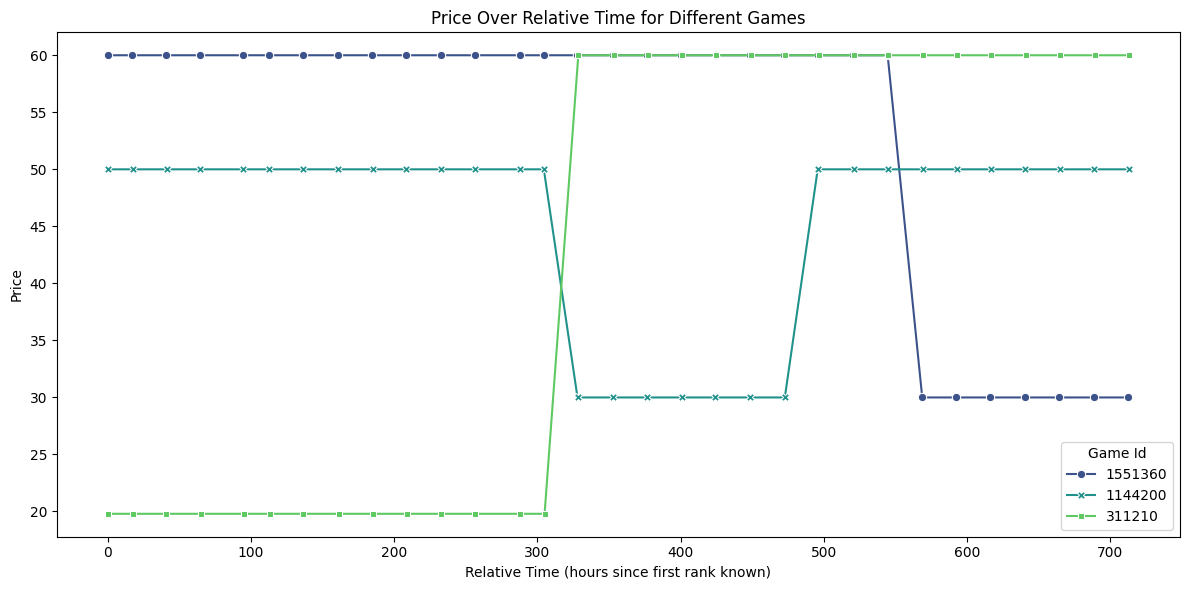

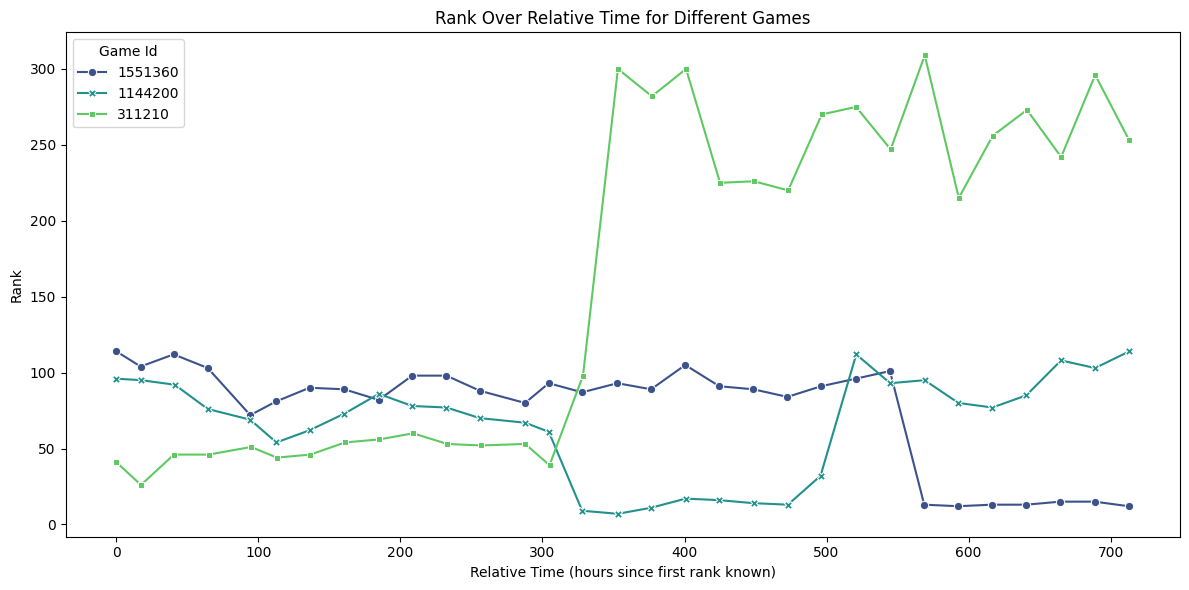

In [5]:
all_games = []


for game in json_data:
    df = pd.DataFrame(game['history'])
    df['game'] = game['steamId']
    df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='ms')
    all_games.append(df)

df_all = pd.concat(all_games)

df_all.dropna(subset='rank', inplace=True)
first_timestamps = df_all.groupby('game')['timeStamp'].min().reset_index()
first_timestamps = first_timestamps.rename(columns={'timeStamp': 'first_timeStamp'})
df_all = df_all.merge(first_timestamps, on='game')

df_all['relative_timeStamp'] = (df_all['timeStamp'] - df_all['first_timeStamp']).dt.total_seconds() / 3600

games_to_keep = df_all['game'].unique()[:3]
sample = df_all[df_all['game'].isin(games_to_keep)]
plt.figure(figsize=(12, 6))
sns.lineplot(data=sample, x='relative_timeStamp', y='price', hue='game', style='game', markers=True, dashes=False, palette='viridis')
plt.title('Price Over Relative Time for Different Games')
plt.xlabel('Relative Time (hours since first rank known)')
plt.ylabel('Price')
plt.legend(title='Game Id')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=sample, x='relative_timeStamp', y='rank', hue='game', style='game', markers=True, dashes=False, palette='viridis')
plt.title('Rank Over Relative Time for Different Games')
plt.xlabel('Relative Time (hours since first rank known)')
plt.ylabel('Rank')
plt.legend(title='Game Id')
plt.tight_layout()
plt.show()

For convenience of representation only a sample of 3 games was drawn from data. 
What we observe is actually a hint for a strong linear relationship between rank and pricing strategy, as for each game change in rank position corresponds to price shift. To analyze it further, let us plot a correlation between these features across all games.

In [6]:
correlation = df_all.groupby('game')[['price', 'rank']].corr().unstack().iloc[:, 1]
correlation.dropna(inplace=True)
correlation_df = correlation.reset_index()
correlation_df.columns = ['game', 'correlation']

mean_correlation = correlation_df['correlation'].mean()
median_correlation = correlation_df['correlation'].median()

fig = px.bar(
    correlation_df,
    x=correlation_df.index,
    y='correlation',
    labels={'x': 'Game', 'y': 'Correlation'},
    title='Correlation Between Price and Rank for Each Game',
    hover_data={'game': True},
)
fig.add_hline(
    y=mean_correlation,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Mean: {mean_correlation:.2f}",
    annotation_position="bottom right",
    annotation_font=dict(size=14, weight='bold', color='black')
)

fig.add_hline(
    y=median_correlation,
    line_dash="dot",
    line_color="blue", 
    annotation_text=f"Median: {median_correlation:.2f}",
    annotation_position="bottom left",
    annotation_font=dict(size=14, weight='bold', color='black')
)


fig.update_xaxes(
    tickvals=[], 
    ticktext=[],  
    title_text=''
)

fig.show()

We see high positive correlation between rank and pricing (excluding outliers). It yields that pricing policies are adjusted to correspond with the current position in games' leaderboard.

Now, let us understand whether pricing has anything to do with user scores and players engagement.

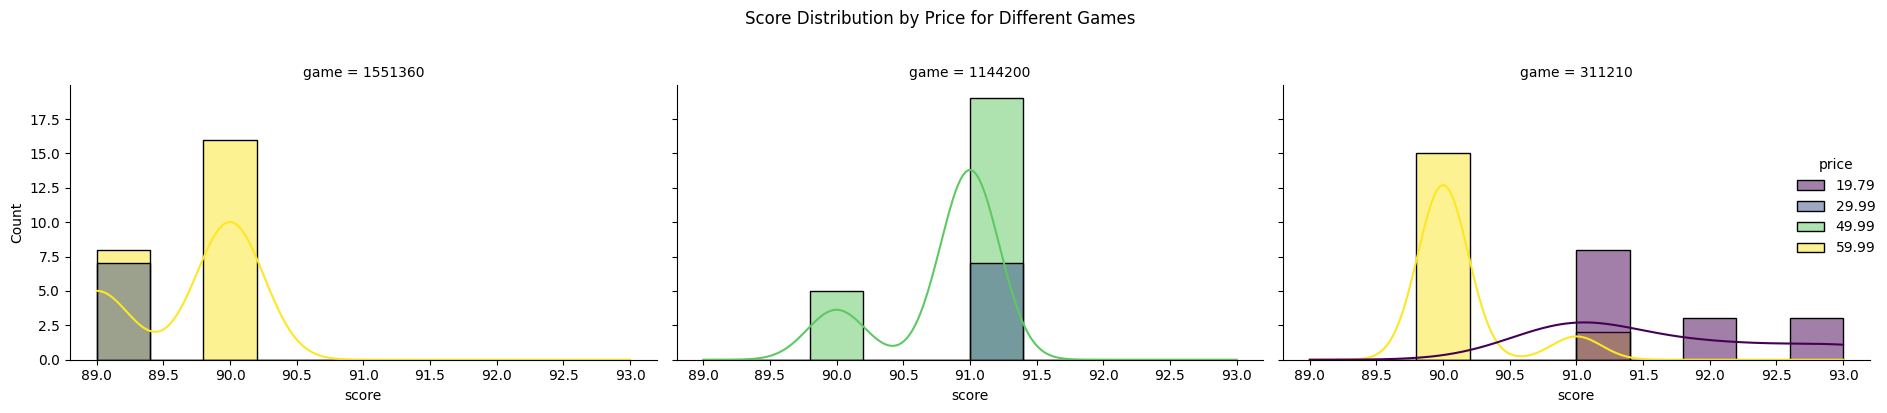

In [7]:
sns.displot(
    data=sample,
    x='score',
    hue='price',
    col='game',
    kind='hist',
    palette='viridis',
    height=4,
    aspect=1.5,
    kde=True
)
plt.suptitle('Score Distribution by Price for Different Games', y=1.02)
plt.tight_layout()
plt.show()

From the plot there is a distribution of score values based on price for each game. Notice how score is stacked for different prices in two first cases, but in the third one score seems to be lower for greater price. To examine how significant is this distinction of price/score pairs for any game, we use - again, correlation.

In [8]:
import logging

# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def kruskal_wallis_test_by_game(df, game_col='game', price_col='price', score_col='score'):
    results = []
    games = df[game_col].unique()
    for game in games:
        game_data = df[df[game_col] == game]
        price_categories = game_data.groupby(price_col)[score_col].apply(list)
        
        if len(price_categories) >= 2:
            try:
                stat, p_value = kruskal(*price_categories)
                results.append({'game': game, 'p_value': p_value})
            except Exception as e:
                # logging.error(f"Ошибка в игре {game}: {e}")
                # logging.error(f"Категории цен {game}: {price_categories}")
                results.append({'game': game, 'p_value': np.nan})
        else:
            results.append({'game': game, 'p_value': np.nan})
    
    return pd.DataFrame(results)


results = kruskal_wallis_test_by_game(df_all)
results = results.sort_values(by='p_value', ascending=False)

fig = px.bar(
    results,
    x='game',
    y='p_value',
    title='Kruskal-Wallis Test Results by Game',
    labels={'p_value': 'p-value', 'game': 'Game'},
    text='p_value',
    hover_data={'game': True}
)
fig.add_hline(y=0.05, line_dash="dash", line_color="red", annotation_text="Significance Level (0.05)")
fig.update_xaxes(range=[-0.5, len(results) - 0.5])

# fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_xaxes(
    tickvals=[], 
    ticktext=[],  
    title_text='Games instances'
)
for x in range(0, len(results), 100):
    fig.add_vline(
        x=x,
        line_dash="dash",
        line_color="grey",
        annotation_text=f"Obs {x}",
        annotation_position="top",
    )

fig.show()

Since price can be used as categorical feature (we are bot interested in absolute value here, and number of unique prices for each game is small), the statistical test - Kruskall-Wallis's test - was used to see if there is significant difference between scores among price categories for each game. 
The plot shows that, indeed, for about 80% of games dataset, the difference is noticable. Which implies that score does depend on price, or vice-versa.

Now we examine if number of players is affected by price somehow:

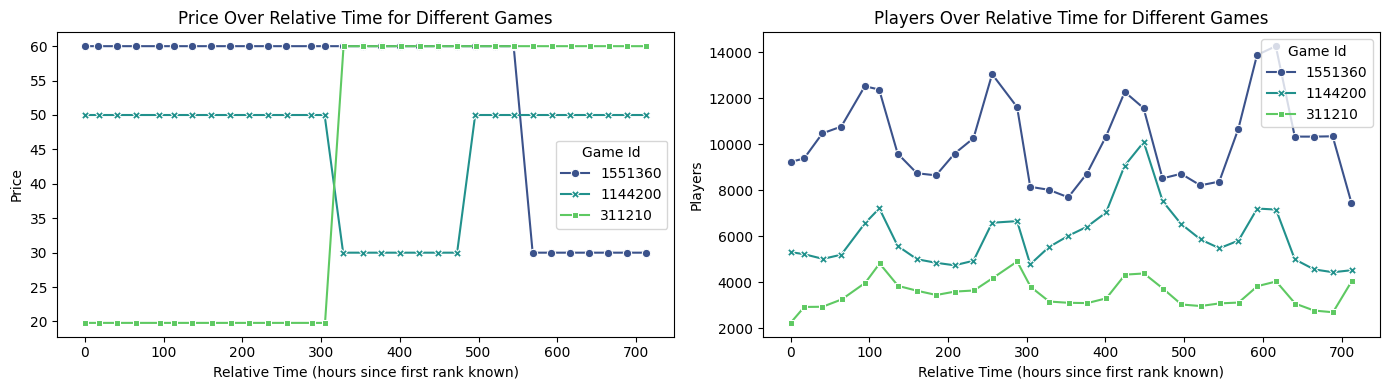

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)
sns.lineplot(
    data=sample,
    x='relative_timeStamp',
    y='price',
    hue='game', 
    style='game',  
    markers=True,  
    dashes=False, 
    palette='viridis', 
    ax=axes[0] 
)
axes[0].set_title('Price Over Relative Time for Different Games')
axes[0].set_xlabel('Relative Time (hours since first rank known)')
axes[0].set_ylabel('Price')
axes[0].legend(title='Game Id')
sns.lineplot(
    data=sample,
    x='relative_timeStamp',
    y='players',
    hue='game', 
    style='game',
    markers=True, 
    dashes=False, 
    palette='viridis',
    ax=axes[1]
)
axes[1].set_title('Players Over Relative Time for Different Games')
axes[1].set_xlabel('Relative Time (hours since first rank known)')
axes[1].set_ylabel('Players')
axes[1].legend(title='Game Id')

plt.tight_layout()
plt.show()


There seems to be no apparent connection between pricing and number of active players, dinamics across different games are more dependent on a given time interval, than on price. 

## Genres comparison

It is also important to distinguish between genres in order to access features related to certain categories of them. 

In [10]:
genres_exploded = genres_df.explode(0)

genre_counts = genres_exploded[0].value_counts()
print(genre_counts.index)

fig = px.pie(
    genre_counts,
    values=genre_counts.values,
    names=genre_counts.index,
    title='Distribution of Game Genres',
    labels={'names': 'Genre', 'values': 'Count'}
)
fig.show()

Index(['Action', 'Adventure', 'Indie', 'Casual', 'RPG', 'Simulation',
       'Strategy', 'Racing', 'Massively Multiplayer', 'Sports', 'Free To Play',
       'Early Access'],
      dtype='object', name=0)


Here, it is clear that action games account for more than 50% of all labels, other games cannot compare in popularity. Second comes the adventure, and Indie is on the third place. Let's not forget that a game includes typically many category labels, so we should analyze genres further.

### Indie vs AAA Games
* How do indie games perform compared to AAA in terms of reviews, sales and player engagement
* Are there specific indie game features that resonate with players

We define AAA Games as those produced by large, well-known publishers, typically with high-development and marketing budgets. These games are often associated with high-quality graphics, complex gameplay, and large-scale production.
The genres related to AAA are:   

    Action

    Adventure

    RPG

    Massively Multiplayer

    Racing

    Sports

We will now compare them to indie games genre.

C:\Users\rto42\AppData\Local\Temp\ipykernel_21644\3976580821.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rto42\AppData\Local\Temp\ipykernel_21644\3976580821.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rto42\AppData\Local\Temp\ipykernel_21644\3976580821.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

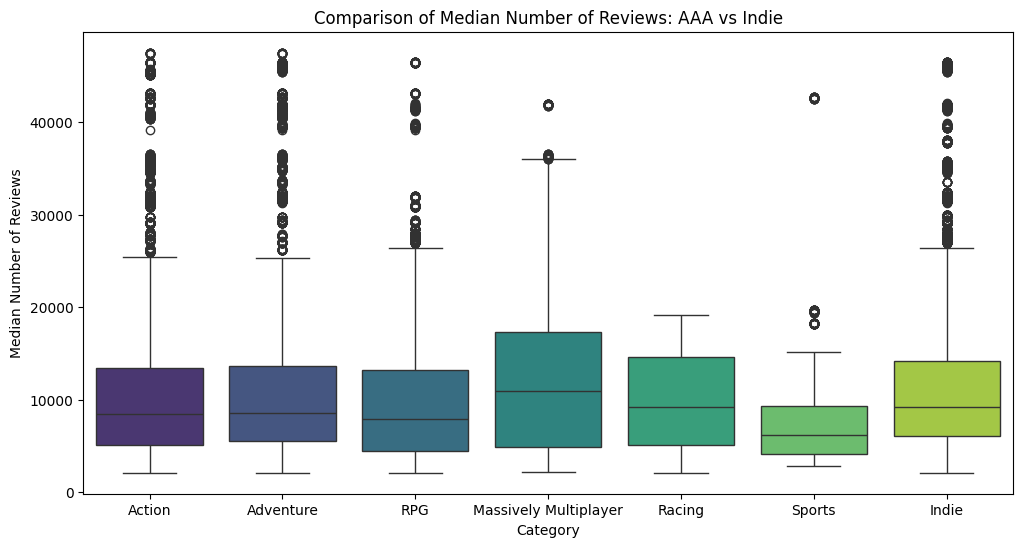

In [11]:
aaa_genres = ['Action', 'Adventure', 'RPG', 'Massively Multiplayer', 'Racing', 'Sports']
indie_genres = ['Indie']

def combine_all_to_list(row):
    all_values = []
    for col in row.index:
        if col != 'steamId': 
            value = row[col]
            if pd.notna(value):
                if isinstance(value, (list, tuple)):
                    all_values.extend(value)
                else:
                    all_values.append(value)
    return all_values

aggregated = genres_df.groupby('steamId').apply(lambda group: combine_all_to_list(group.iloc[0]), include_groups=False).reset_index()
aggregated = aggregated.rename(columns={0: 'genres'})

result = pd.DataFrame()
for i, genre in enumerate(aaa_genres + indie_genres):
    ids_to_include = aggregated[
        aggregated['genres'].apply(lambda g: genre in g)
    ]['steamId']

    df_filtered = df_all[df_all['game'].isin(ids_to_include)]
    df_filtered.loc[:, 'genre'] = genre
    result = pd.concat([result, df_filtered], ignore_index=True)

# plt.figure(figsize=(12, 6))
# sns.boxplot(data=result, x='genre', y='reviewScore', palette='viridis')
# plt.title('Comparison of Median Review Scores: AAA vs Indie')
# plt.xlabel('Category')
# plt.ylabel('Median Review Score')
# plt.show()
lower_bound = result['reviews'].quantile(0.05)
upper_bound = result['reviews'].quantile(0.95)
result = result[(result['reviews'] >= lower_bound) & (result['reviews'] <= upper_bound)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=result, x='genre', y='reviews', palette='viridis')
plt.title('Comparison of Median Number of Reviews: AAA vs Indie')
plt.xlabel('Category')
plt.ylabel('Median Number of Reviews')
plt.show()